In [1]:
# start auf keko: nohub python3 <file.py> > train.log & bg
# um es im hintergrund laufen zu lassen 
# coding: utf-8

import matplotlib
%matplotlib inline
matplotlib.use('Agg') # necessary for linux kernal
#get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
from matplotlib.colors import NoNorm

import os
import numpy as np
from numpy import random
np.random.seed(7)
import keras
from keras import layers, models
from keras.models import Sequential
from keras.callbacks import History
from keras.layers.core import Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers import MaxPooling2D, Conv2DTranspose
from keras import backend as K

from keras.layers import Dense, Input
from keras import Model
from functools import partial


import tensorflow as tf

from osgeo import gdal
from sklearn.model_selection import train_test_split
from skimage.util.shape import view_as_windows

from skimage import feature
from skimage.morphology import square

from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk
#from skimage.util import invert

from PIL import Image

import itertools
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


import time

from time import gmtime, strftime
timestr = strftime("%Y-%m-%d %H-%M-%S", gmtime())


# from yu
def check_and_create(out_dir):
    if os.path.isdir(out_dir) == False:
        os.mkdir(out_dir)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/dist-packages/z

In [2]:
############ Path Setting ##############

#trainPath = r"./Data/small/"
trainPath = r"./Data_/geb25/"
#trainPath = r"./Data/Training_Validation/" 
testPath = r"./Data_/test/geb25/" 
#tmpPath = r"./Data/tmp_data2/"
tmpPath = r"./Data_/tmp_data/"


outPath = r"Prediction/"
check_and_create(outPath)
check_and_create(outPath + timestr)
outPath = outPath + timestr + "/"


from data_helper import readImg, imagePatches

# functions to remove fully black images from heatmap and target data, and all the correspondences
# remove white == 255
def removeBlackImg(img_patch):
    patch_list = []
    patch_list_new = []
    for i in range(len(img_patch)):
        patch_list.append(img_patch[i])
        if i == 2:
            print("patch i: nur weiss oder schwarz ?",patch_list[i].max(), patch_list[i].min())
        if patch_list[i].max() != patch_list[i].min():
            patch_list_new.append(img_patch[i])
    return patch_list_new

# remove roads if heats are black
def removeCorrespondence(road, heat):  
    patch_road_list = []
    patch_heat_list = []
    patch_road_list_new = []
    for i in range(len(road)):
        patch_road_list.append(road[i])
        patch_heat_list.append(heat[i])
        if patch_heat_list[i].max() != 255:
            patch_road_list_new.append(road[i])
    return patch_road_list_new
# remove roads if heats are black

# remove correspondence, if one of both patches contains only one Grayvalue
def removeCorrespondenceAll(road, heat, weight):  
    print("len road / heat: ", len(road), len(heat))
    patch_road_list = []
    patch_heat_list = []
    patch_weight_list = []
    for i in range(len(road)):
        #patch_road_list.append(road[i])
        #patch_heat_list.append(heat[i])
        if road[i].max() != road[i].min():
            if heat[i].max() != heat[i].min():
                #print("appending image patches heat and road",i)
                patch_road_list.append(road[i])
                patch_heat_list.append(heat[i])
                patch_weight_list.append(weight[i])
    return patch_road_list, patch_heat_list, patch_weight_list

def prediction_independent(model_ex1, image_arr):    
    conc2 = np.reshape(model_ex1.predict(np.reshape(image_arr, (1, image_arr.shape[0], image_arr.shape[1], 1))), 
                   (image_arr.shape[0], image_arr.shape[1]))
    return conc2

# cut the image to avoid shape error
def cut_image(image_arr):
    
    print("Original:", image_arr.shape)
    
    if image_arr.shape[0] % 4 != 0:
        n = image_arr.shape[0] % 4
        new_x = image_arr.shape[0] - n
    else:
        new_x = image_arr.shape[0]

    if image_arr.shape[1] % 4 != 0:
        n = image_arr.shape[1] % 4
        new_y = image_arr.shape[1] - n
    else:
        new_y = image_arr.shape[1]
    
    image_arr = image_arr[:new_x, :new_y]
    print("Clipped:", image_arr.shape)

In [3]:
# create loss map
# inspired by serras et al. 
# idee: bestimmte bildstrukturen "bestrafen", auf die das lernverfahren zunächst direkt anspringen
# würde: bei serras sind es sehr dicke linien, die das system betonen und demgegenüber die dünneren
# benachteiligen würde. 
# lösung: zusätzlich eine loss map einführen, mit der loss gewichtet wird: 
# in einem filter gegebener breite B wird ein histogramm angelegt; der wert des histogramms, in den
# das zentralpixel fällt, wird als e^-(wert) genommen und bildet das gewicht: 
# bsp: breiter schwarzer streifen -> sehr viele schwarze werte, wenig weisse; wert der schwarzen ist hoch
# -> e^-hoher wert führt zu einem geringen gewicht
# umgekehrt: schmaler schwarzer streifen: wenig schwarze nachbarn, viel weiss; schwarz hat wenige bins
# -> e^-niedriger wert führt zu einem hohen gewicht

# loss map wird von targetbild errechnet; parameter: filterbreite b und anzahl bins nbins    
# bild: schwarze objekte auf weissem hintergrund

import skimage

#target_image  = r"geb5.jpg"
def create_loss_map(target_image,dist):
    print("create_loss_map: ----- target image: ",target_image)
    
    # Read heatmap
    image = gdal.Open(target_image)
    # print("image in readimg : ",target_image)
    # Get band of heatmap, it's gray scale image!
    img_band = image.GetRasterBand(1)
    # Read the image as array
    image = img_band.ReadAsArray()
    
    print("extrem-grauwerte : ", image.max()," und ", image.min())
    
    # Normalize the pixel values in the range 0-1 acc. to max. normalization
    #image = (image - image.min()) / (image.max() - image.min())
    #image = invert(image)
    #t_img = image.astype('float32')
    t_img = image
    print("computing edges from image ",target_image)
    edges1 = skimage.filter.canny(t_img)
    #edges2 = feature.canny(im, sigma=3)

    #create image with 4 pixels boundaries
    dilat = dilation(edges1, square(dist))
    dilat = dilat.astype('float32')


    fig = plt.figure(figsize=(dilat.shape[1] / 1000, dilat.shape[0] / 1000), dpi=100, frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    
    plt.imshow(dilat, cmap=plt.cm.gray)
    fig.savefig(target_image[:-4] + '_boundary.png', dpi=1000)
    print("image saved ",target_image[:-4] + '_boundary.png')
    
    return dilat

In [4]:
# function to load a saved model
def LoadModel(model_json):
    from keras.models import model_from_json
    json_file = open(model_json)
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    return loaded_model


##### function to calculate evaluation parameters (F1-Score, Precision, Recall) ######
def evaluation(model, x_test, y_test, patch_size):
    precision = []
    recall = []
    f1Score = []
    import math
    for k in range(len(x_test_sim)):
        y_pred = model.predict(x_test_sim[k:k + 1])
        y_pred = np.reshape(y_pred, (32 * 32))

        y_true = y_test_sim[k:k + 1]
        y_true = np.reshape(y_true, (32 * 32))

        TP = 0
        FP = 0
        FN = 0
        TN = 0

        y_pred = np.round(y_pred)
        for i in range(len(y_pred)):
            if y_true[i] == y_pred[i] == 1:
                TP += 1
            elif y_pred[i] == y_true[i] == 0:
                TN += 1
            elif y_pred[i] == 1 and y_true[i] != y_pred[i]:
                FP += 1
            elif y_pred[i] == 0 and y_true[i] != y_pred[i]:
                FN += 1

        precision.append(TP / (TP + FP + K.epsilon()))  # completeness
        recall.append(TP / (TP + FN))  # correctness
        beta = 1
        f1Score.append((math.pow(beta, 2) + 1) * TP / ((math.pow(beta, 2) + 1) * TP + math.pow(beta, 2) * FN + FP))
        # eval_list = [precision,  recall, f1Score]

    avg_precision = sum(precision) / len(precision)
    avg_recall = sum(recall) / len(precision)
    avg_f1score = sum(f1Score) / len(precision)
    avg_eval_param = [avg_precision, avg_recall, avg_f1score]
    return avg_eval_param

In [5]:
_EPSILON = 10e-8

def IoU(yTrue,yPred):  
    I = tf.multiply(yTrue, yPred, name="intersection")
    U = yTrue + yPred - I + _EPSILON
    
    IoU = tf.reduce_sum(I) / tf.reduce_sum(U)
    return -tf.log(IoU + _EPSILON) 

#intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
#    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
#    jac = (intersection + smooth) / (sum_ - intersection + smooth)
#return (1 - jac) * smooth


#In das model brauchen Sie nur das loss name ändern, z.B. 

# Compile model with Adam optimizer and binary cross entropy loss function
#Standard Loss: 

#model.compile(optimizer=optimizer, loss= 'binary_crossentropy', metrics=['acc'])

#Custom Loss: 
#model.compile(optimizer=optimizer, loss=IoU, metrics=['acc'])

def loss_boundary(loss_map):  
    def my_loss_function(y_true, y_pred):
        loss = K.mean(K.pow(y_true-y_pred,2)*loss_map)
        return loss
    return my_loss_function

    #I = tf.multiply(yTrue, yPred, name="intersection")
    #U = yTrue + yPred - I + _EPSILON
    
    #IoU = tf.reduce_sum(I) / tf.reduce_sum(U)
    #return -tf.log(IoU + _EPSILON) 

def custom_loss_4(y_true, y_pred, weights):
    return K.mean(K.abs(y_true - y_pred) * weights)


#beispiel:
#def customLoss(layer_weights, val = 0.01):
#
#    def lossFunction(y_true,y_pred):    
#        loss = mse(y_true, y_pred)
#        loss += K.sum(val, K.abs(K.sum(K.square(layer_weights), axis=1)))
#        return loss
#
#    return lossFunction
#
#model.compile(loss=customLoss(weights,0.03), optimizer =..., metrics = ...) 

#input_layer = Input(shape=(5,))
#weights_tensor = Input(shape=(5,))
#out = Dense(5)(input_layer)
#cl4 = partial(custom_loss_4, weights=weights_tensor)
#model = Model([input_layer, weights_tensor], out)
#model.compile('adam', cl4)
#model.fit(x=[train_X, weights], y=train_Y, epochs=10)

##### Building the CNN archıtecture with "Sequential Model" 
##### (model looks like autoencoder)
def create_model(optimizer, input_shape):
    model = Sequential()
    
    droprate = 0.3

    model.add(Conv2D(filters=24, kernel_size=(5, 5),
              strides=(1, 1), padding='same',
              activation='relu', input_shape=input_shape, kernel_initializer='random_uniform',
              name="flat_conv_a"))
    model.add(Dropout(droprate))
    
    model.add(Conv2D(filters=24, kernel_size=(5, 5),
              strides=(1, 1), padding='same',
              activation='relu',name="flat_conv_b"))
    model.add(Dropout(droprate))
    
    ## Encoding (down-sampling) ###   
    model.add(Conv2D(filters=24, kernel_size=(5, 5),
                     strides=(2, 2), padding='same',
                     activation='relu', #input_shape=input_shape, kernel_initializer='random_uniform',
                     name="down_conv_1"))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_1"))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_2"))
    model.add(Dropout(droprate))
    ##############################################################################
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(2, 2), padding='same',
                     activation='relu', name="down_conv_2"))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=128, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_3"))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_4"))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_5"))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_6"))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=256, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_7"))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=128, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_8"))
    model.add(Dropout(droprate))
    ###############################################################################
    model.add(UpSampling2D(size=(2, 2), name='up_samp_1'))
    
    model.add(Conv2D(filters=64, kernel_size=(4, 4),
                     strides=(1, 1), padding='same',
                     activation='relu', name="up_conv_1"))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_9"))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_10"))
    model.add(Dropout(droprate))
    ###############################################################################
    model.add(UpSampling2D(size=(2, 2), name='up_samp_2'))
    
    model.add(Conv2D(filters=24, kernel_size=(4, 4),
                     strides=(1, 1), padding='same',
                     activation='relu', name="up_conv_2"))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=12, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='relu', name="flat_conv_11"))
    model.add(Dropout(droprate))

    model.add(Conv2D(filters=1, kernel_size=(3, 3),
                     strides=(1, 1), padding='same',
                     activation='sigmoid', name="flat_conv_12"))
    # model.add(Activation(our_activation))
    model.add(Dropout(droprate))
    
    # Compile model with Adam optimizer and binary cross entropy loss function
    #orig . von hier
    #model.compile(optimizer=optimizer,
    #              loss='binary_crossentropy',
    #              metrics=['acc'])
    #orig . bis hier
    #model.compile(optimizer=optimizer, loss=IoU, metrics=['acc'])

    # wandeln des sequentiellen modells in funktionales zu wandeln, weil ich dort einen 
    # weiteren input (weights) angeben kann.   
    # seqential model is called seqmodel   
#    input_layer = layers.Input(batch_shape=seqmodel.layers[0].input_shape)
#    prev_layer = input_layer
#    for layer in seqmodel.layers:
#        prev_layer = layer(prev_layer)
#    funcmodel = models.Model([input_layer], [prev_layer])
    print("----seq-model summary -----------")
    model.summary()
    
    input_layer = layers.Input(batch_shape=model.layers[0].input_shape)
    print("input layer. ",input_layer)
    print("input shape : ",input_shape)
    #print("batch - shape : ",batch_shape=model.layers[0].input_shape)
    weights_tensor = layers.Input(input_shape)
    print("weights_tensor: ",weights_tensor)

    prev_layer = input_layer
    for layer in model.layers:
        prev_layer = layer(prev_layer)

    #model = Model(inputs=[visible1, visible2], outputs=output)

    funcmodel = Model(inputs=[input_layer,weights_tensor], outputs = [prev_layer])
    
    cl4 = partial(custom_loss_4, weights=weights_tensor)
    #model.compile('adam', cl4)
    #model.summary()
    #model.fit(x=[train_X, weights], y=train_Y, epochs=10)

    funcmodel.compile(optimizer=optimizer,
            loss=cl4,
            metrics=['acc'])
    
    funcmodel.compile(optimizer=optimizer,
            loss='mae',
            metrics=['acc'])

    funcmodel.summary()
    
    return funcmodel

#model.compile(optimizer=optimizer, loss= 'binary_crossentropy', metrics=['acc'])

#Custom Loss: 
#model.compile(optimizer=optimizer, loss=IoU, metrics=['acc'])
#model_ex1.summary()
    

In [6]:
# Order the image dimension acc. to TensorFlow (batc_hsize, rows, cols, channels)
K.set_image_dim_ordering('tf')

# set the working directory
#os.chdir(r'F:\sercan\input_images')
PATH = os.getcwd()
#plt.gray()
#plt.show()

# load simulated heat map (TRAJECTORY SIMULATION) and target road for Hannover ####
#sim_heatmap_hannover = readImg(r"input2.tif")
#sim_road_hannover = readImg(r"output2.tif")

print("trainPath: ",trainPath)
#2traininput_inv.png


def generate_input(First):
    print("generate_input -------------------")
    # image_input  = trainPath + r"2traininput_inv.png"
    # image_output = trainPath + r"2trainoutput_inv.png"
    # typify
    ##image_input  = trainPath + r"input2.tif"
    ##image_output = trainPath + r"output2.tif"
    p_size_1 = 128

    if First: 
        # geb25 - target scale 1:25.000
        image_input  = trainPath + r"gebex.png"
        image_output = trainPath + r"geb25ex.png"
        #loss_map_file = trainPath + r"geb25ex_boundary_b.png"
        #loss_map_file = trainPath + r"black_boundary.png"

        
        print("output image: ",image_output)
        print("image input: ",image_input)
        
        #fns_input = [trainPath + r"input2.tif"]
        #fns_output = [trainPath + r"output2.tif"]
        
        sim_heatmap_hannover = readImg(image_input)
        sim_road_hannover = readImg(image_output)
        
        # read loss map (or create it from output-file)
        dist = 30
        loss_map = create_loss_map(image_input,dist)
        #loss_map = (loss_map - loss_map.min()) / (loss_map.max() - loss_map.min())
        
        #loss_map = readImg(loss_map_file)
        
        # p_size_1 = 128
        
        # create overlapping training data
        sim_hm_patches_overlap = imagePatches(sim_heatmap_hannover, p_size_1, p_size_1, int(p_size_1))
        sim_road_patches_overlap = imagePatches(sim_road_hannover, p_size_1, p_size_1, int(p_size_1))
        loss_map_overlap = imagePatches(loss_map, p_size_1, p_size_1, int(p_size_1))
        
        
        #sim_road_patches_overlap_new = removeCorrespondence(sim_road_patches_overlap, sim_hm_patches_overlap)
        #sim_hm_patches_overlap_new = removeCorrespondence(sim_hm_patches_overlap, sim_road_patches_overlap)
        #sim_road_patches_overlap_new_new = removeBlackImg(sim_road_patches_overlap)
        
        #sim_road_patches_32_new_new , sim_hm_patches_32_new = removeCorrespondenceAll(sim_road_patches_overlap, sim_hm_patches_overlap)
        # remove correspondence -> mit loss map
        sim_road_patches_32_new_new, sim_hm_patches_32_new, loss_map_new = removeCorrespondenceAll(sim_road_patches_overlap, 
                                                                                      sim_hm_patches_overlap, loss_map_overlap)
                
        #sim_hm_patches_32_new = sim_hm_patches_32_new + sim_hm_patches_overlap_new
        #sim_road_patches_32_new_new = sim_road_patches_32_new_new + sim_road_patches_overlap_new_new
        
        #sim_hm_patches_32_new = sim_hm_patches_overlap_new
        #sim_road_patches_32_new_new = sim_road_patches_overlap_new_new
        
        print("removed non-filled patches: ", )
        num_img = len(sim_hm_patches_32_new)
        #print("anzahl bilder (vor dem löschen von schwarzen) ", num_img)
        #print("anzahl bilder (nach dem löschen von schwarzen) ", len(sim_road_patches_32_new_new))
        
        print("removed patches with either pure black or white pixels ")
        
        sim_road_patches_used = sim_road_patches_32_new_new
        sim_hm_patches_used = sim_hm_patches_32_new
        p_size_used = p_size_1
        
        print("trained with patch size : ",p_size_used)
        print("check: road/sim-patches : ",len(sim_road_patches_used), len(sim_hm_patches_used))
        
        ### experience 1 - simulated hm
        #index_list_sim = list(range(len(sim_hm_patches_32_new)))
        #index_list_sim = list(range(len(sim_hm_patches_used)))
        #random.shuffle(index_list_sim)
     
        #idx_sim = 1000
        idx_sim = 1000
        if len(sim_road_patches_used) < idx_sim*10:
            idx_sim = int(0.1*len(sim_road_patches_used))
            
        print("idx_sim is: ",idx_sim)
            
        # 30 % trainingsdaten
        # idx_sim = int(len(sim_road_patches_used)*0.3)
        print("number of training patches : ",len(sim_road_patches_used)-idx_sim)
        print("number of test patches     : ",idx_sim)
        
        #old
        ### experience 1 - simulated hm
        print("laenge originaldaten ", len(sim_hm_patches_32_new))
        len_orig = len(sim_hm_patches_32_new)
        
        #create list wit len_orig values
        index_list_sim_all = list(range(len(sim_hm_patches_32_new)))
        random.shuffle(index_list_sim_all)
        
        # maximum number of patches 20.000 - or original number of patches
        max_patches = 20000
        max_patches = min(max_patches,len(sim_hm_patches_32_new))
        print("number of patches used: ",max_patches)
        
        index_list_sim = index_list_sim_all[:max_patches]
        
        index_list_test_sim = index_list_sim[-idx_sim:]
        index_list_test_sim.sort()
        sim_hm_test = [sim_hm_patches_32_new[i] for i in index_list_test_sim]
        sim_road_test = [sim_road_patches_32_new_new[i] for i in index_list_test_sim]
                
        index_list_train_sim = index_list_sim[:-idx_sim]
        index_list_train_sim.sort()
        sim_hm_train = [sim_hm_patches_32_new[i] for i in index_list_train_sim]
        sim_road_train = [sim_road_patches_32_new_new[i] for i in index_list_train_sim]

        #patches with weighted loss data
        # create only for train-data sets
        weight_loss_map  = [loss_map_new[i] for i in index_list_train_sim]
        # also for test-data sets
        weight_loss_map_test = [loss_map_new[i] for i in index_list_test_sim]
        
        
        x_train_sim = np.reshape(sim_hm_train, (len(sim_hm_train), p_size_1, p_size_1, 1))
        y_train_sim = np.reshape(sim_road_train, (len(sim_road_train), p_size_1, p_size_1, 1))
        x_test_sim = np.reshape(sim_hm_test, (len(sim_hm_test), p_size_1, p_size_1, 1))
        y_test_sim = np.reshape(sim_road_test, (len(sim_road_test), p_size_1, p_size_1, 1))
        
        y_weights = np.reshape(weight_loss_map, (len(weight_loss_map), p_size_1, p_size_1, 1))
        
        y_weights_test = np.reshape(weight_loss_map_test, (len(weight_loss_map_test), p_size_1, p_size_1, 1))
    
        # save image patch arrays
        print("storing image patches")
        np.save("x_train_sim.npy", x_train_sim)
        np.save("y_train_sim.npy", y_train_sim)
        np.save("x_test_sim.npy", x_test_sim)
        np.save("y_test_sim.npy", y_test_sim)
        np.save("y_weights.npy", y_weights)
        np.save("y_weights_test.npy", y_weights_test)
        
    else:
        # load image patch arrays
        print("loading stored image patches ")        
        x_train_sim = np.load("x_train_sim.npy")
        y_train_sim = np.load("y_train_sim.npy")
        x_test_sim = np.load("x_test_sim.npy")
        y_test_sim = np.load("y_test_sim.npy")
        y_weights = np.load("y_weights.npy")
        y_weights_test = np.load("y_weights_test.npy")
    
    # plt.imshow(np.reshape(x_test_sim[2], (p_size_1,p_size_1)))
    # plt.imshow(np.reshape(y_test_sim[2], (p_size_1,p_size_1)))
    
    
    plt.figure(figsize=(15,15))

#    plt.subplot(131)
#    plt.imshow(im,cmap=plt.cm.gray)
#    plt.axis('off')
#    plt.subplot(132)

    
    plt.subplot(331)
    plt.imshow(np.reshape(x_train_sim[1], (p_size_1,p_size_1)),cmap=plt.cm.gray)
    plt.subplot(332)
    plt.imshow(np.reshape(y_train_sim[1], (p_size_1,p_size_1)),cmap=plt.cm.gray)
    plt.subplot(333)
    plt.imshow(np.reshape(y_weights[1], (p_size_1,p_size_1)),cmap=plt.cm.gray)
    plt.subplot(334)
    plt.imshow(np.reshape(x_train_sim[6], (p_size_1,p_size_1)),cmap=plt.cm.gray)
    plt.subplot(335)
    plt.imshow(np.reshape(y_train_sim[6], (p_size_1,p_size_1)),cmap=plt.cm.gray)    
    plt.subplot(336)
    plt.imshow(np.reshape(y_weights[6], (p_size_1,p_size_1)),cmap=plt.cm.gray)
    print("figure plotted")

    plt.subplot(337)
    plt.imshow(np.reshape(x_train_sim[10], (p_size_1,p_size_1)),cmap=plt.cm.gray)
    plt.subplot(338)
    plt.imshow(np.reshape(y_train_sim[10], (p_size_1,p_size_1)),cmap=plt.cm.gray)    
    plt.subplot(339)
    plt.imshow(np.reshape(y_weights[10], (p_size_1,p_size_1)),cmap=plt.cm.gray)
    print("figure plotted")
        
    input_shape1 = (None, None, 1) #x_train_sim[0].shape
    print('Input Shape of the models', x_train_sim.shape)
    print('Input Shape of the weights', y_weights.shape)
    
    return input_shape1, x_train_sim, y_train_sim, x_test_sim, y_test_sim, y_weights, y_weights_test



trainPath:  ./Data_/geb25/


start training - or use existing data:  True
generate_input -------------------
output image:  ./Data_/geb25/geb25ex.png
image input:  ./Data_/geb25/gebex.png
create_loss_map: ----- target image:  ./Data_/geb25/gebex.png
extrem-grauwerte :  220  und  0
computing edges from image  ./Data_/geb25/gebex.png
image saved  ./Data_/geb25/gebex_boundary.png
len road / heat:  24336 24336
removed non-filled patches: 
removed patches with either pure black or white pixels 
trained with patch size :  128
check: road/sim-patches :  14318 14318
idx_sim is:  1000
number of training patches :  13318
number of test patches     :  1000
laenge originaldaten  14318
number of patches used:  14318
storing image patches
figure plotted
figure plotted
Input Shape of the models (13318, 128, 128, 1)
Input Shape of the weights (13318, 128, 128, 1)
Input Shape of the models after data read (13318, 128, 128, 1)


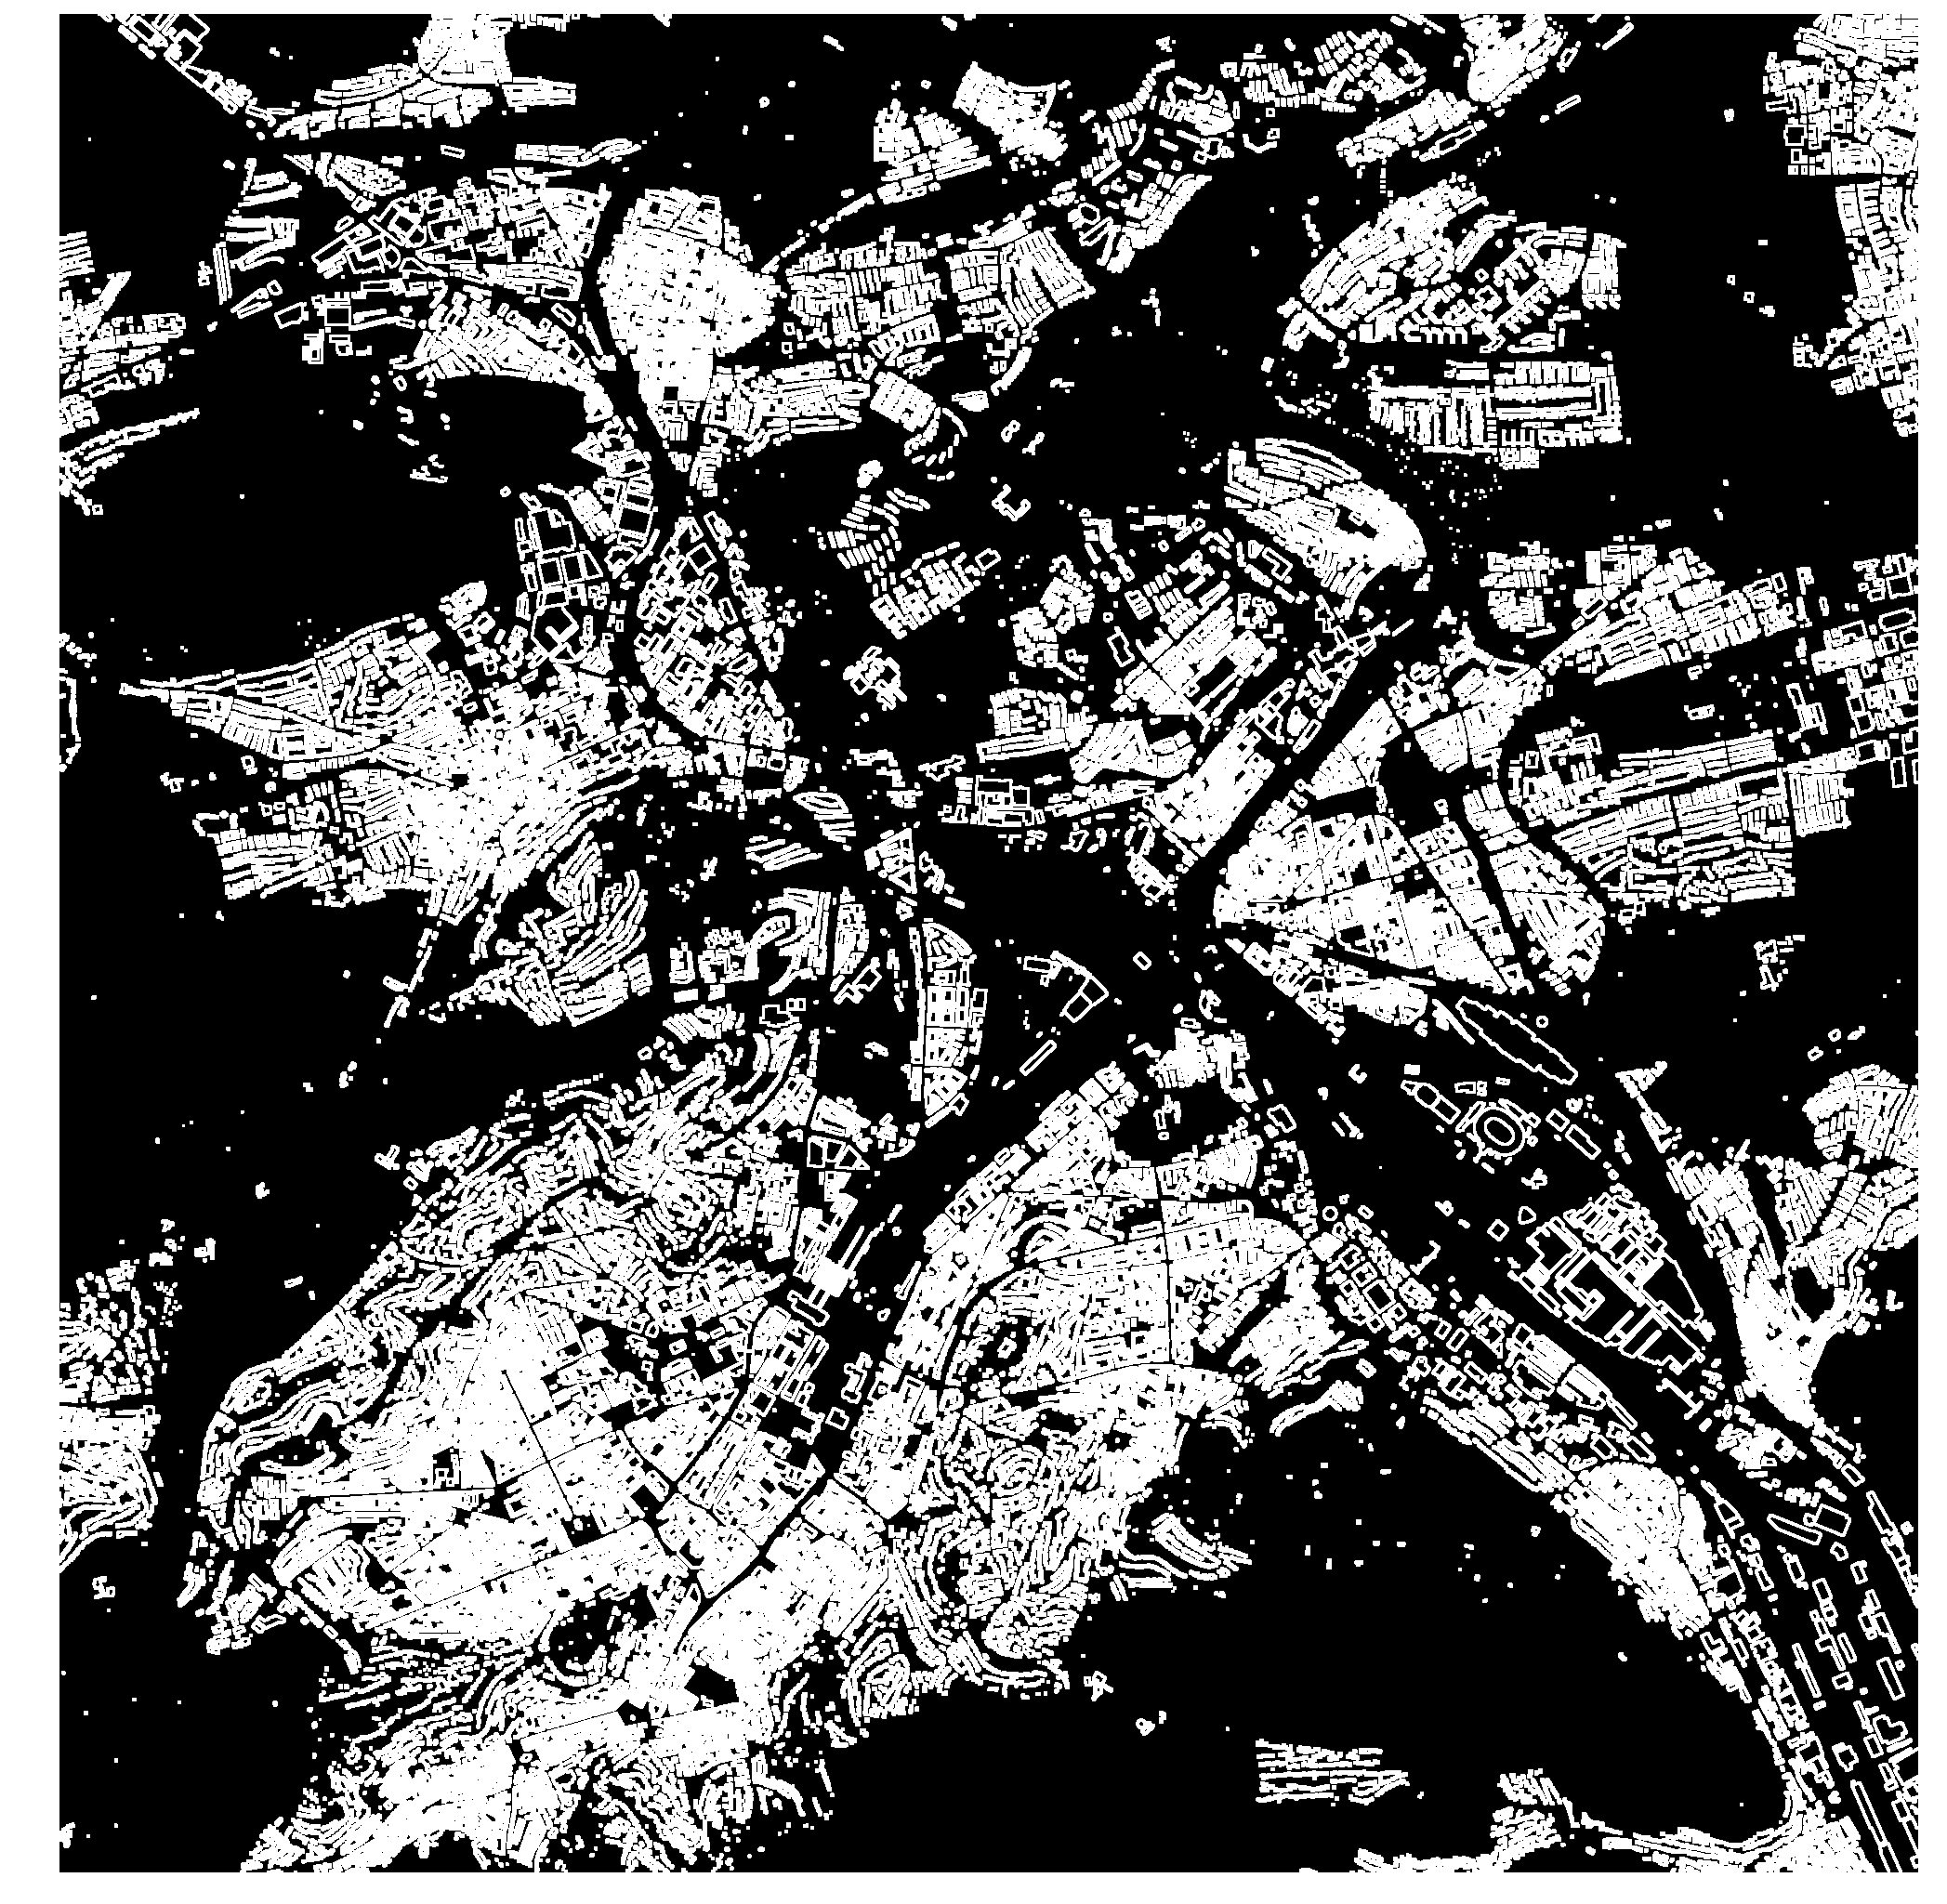

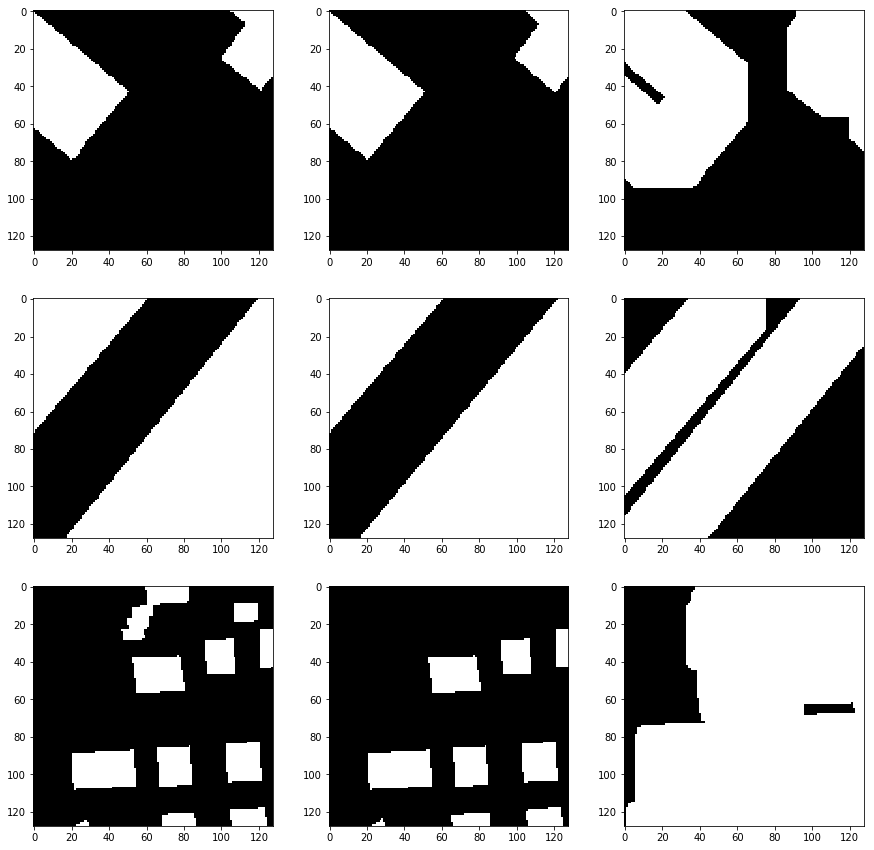

In [7]:
First = True
# store image patch arrays
start_training = True
print("start training - or use existing data: ",start_training)
 
if start_training:    
    input_shape1, x_train_sim, y_train_sim, x_test_sim, y_test_sim, y_weights, y_weights_test = generate_input(First)

    print('Input Shape of the models after data read', x_train_sim.shape)


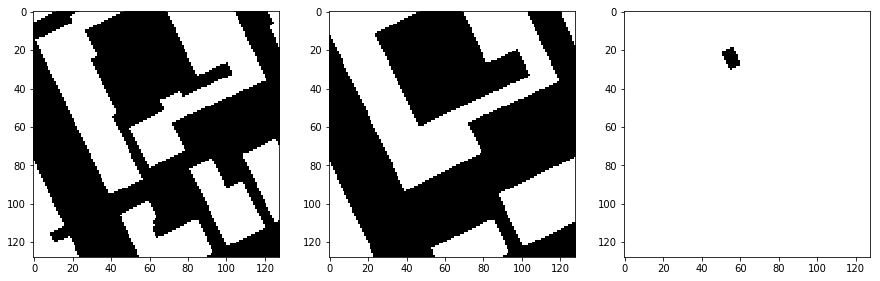

In [8]:
def show_examples(x_train_sim, y_train_sim, y_weights,
                  index, p_size_1 = 128):
    
    plt.figure(figsize=(15,15))

    plt.subplot(131)
    plt.imshow(np.reshape(x_train_sim[index], (p_size_1,p_size_1)),cmap=plt.cm.gray)
    plt.subplot(132)
    plt.imshow(np.reshape(y_train_sim[index], (p_size_1,p_size_1)),cmap=plt.cm.gray)
    plt.subplot(133)
    plt.imshow(np.reshape(y_weights[index], (p_size_1,p_size_1)),cmap=plt.cm.gray)

show_examples(x_train_sim, y_train_sim, y_weights, 11347)

In [9]:
y_weights[11347]

array([[[ 255.],
        [ 255.],
        [ 255.],
        ..., 
        [ 255.],
        [ 255.],
        [ 255.]],

       [[ 255.],
        [ 255.],
        [ 255.],
        ..., 
        [ 255.],
        [ 255.],
        [ 255.]],

       [[ 255.],
        [ 255.],
        [ 255.],
        ..., 
        [ 255.],
        [ 255.],
        [ 255.]],

       ..., 
       [[ 255.],
        [ 255.],
        [ 255.],
        ..., 
        [ 255.],
        [ 255.],
        [ 255.]],

       [[ 255.],
        [ 255.],
        [ 255.],
        ..., 
        [ 255.],
        [ 255.],
        [ 255.]],

       [[ 255.],
        [ 255.],
        [ 255.],
        ..., 
        [ 255.],
        [ 255.],
        [ 255.]]], dtype=float32)

In [10]:
if start_training: 
    opt1 = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
    model_ex1 = create_model(opt1, input_shape1)
    print("model 1 created : ",model_ex1)

----seq-model summary -----------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flat_conv_a (Conv2D)         (None, None, None, 24)    624       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, None, 24)    0         
_________________________________________________________________
flat_conv_b (Conv2D)         (None, None, None, 24)    14424     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, None, 24)    0         
_________________________________________________________________
down_conv_1 (Conv2D)         (None, None, None, 24)    14424     
_________________________________________________________________
dropout_3 (Dropout)          (None, None, None, 24)    0         
_________________________________________________________________
flat_conv_1 (Conv2D)         (None, None, 

In [11]:
##### Train the model
if start_training: 
    start = time.time()
    print("start training")

    History1 = History()
#    hist1 = model_ex1.fit(x_train_sim, y_train_sim,
    print("eingabedaten ")
    print("x  -- ",x_train_sim.shape)
    print("w  -- ",y_weights.shape)
    print("y  -- ",y_train_sim.shape)
    print("x  -- ",x_test_sim.shape)
    print("y  -- ",y_test_sim.shape)
    print("y-weights  -- ",y_weights_test.shape)

    hist1 = model_ex1.fit(x=[x_train_sim, y_weights], y = [y_train_sim],
                      #batch_size=16,
                      #small: 
                      batch_size=16,
                      epochs=50,
                      #small 
                      #epochs = 2,
                      verbose=1,
                      shuffle=True,
                      callbacks=[History1, 
                                 EarlyStopping(patience = 10), 
                                 ReduceLROnPlateau(patience = 10, verbose = 0),
                                 #ModelCheckpoint(outPath + "weights.hdf5", 
                                 #                save_best_only = True, 
                                 #                save_weights_only = False)
                                ],
                      validation_data=([x_test_sim, y_weights_test], y_test_sim)
                      )

#    hist1 = model_ex1.fit(x_train_sim, y_train_sim,
#                      batch_size=16,
#                      epochs = 3,
#                      verbose=1,
#                      shuffle=True,
# #                     callbacks=[History1], 
#                      callbacks=[History1, 
#                                 EarlyStopping(patience = 10), 
#                                 ReduceLROnPlateau(patience = 10, verbose = 0),
#                                 ModelCheckpoint(outPath + "weights.hdf5", 
#                                                 save_best_only = True, 
#                                                 save_weights_only = False)],
#                      validation_data=([x_test_sim, y_weights_test], y_test_sim)
#                      )



    print("Training reached epoch's end. It took: {} min.".format((time.time()-start)/60))

    

start training
eingabedaten 
x  --  (13318, 128, 128, 1)
w  --  (13318, 128, 128, 1)
y  --  (13318, 128, 128, 1)
x  --  (1000, 128, 128, 1)
y  --  (1000, 128, 128, 1)
y-weights  --  (1000, 128, 128, 1)
Train on 13318 samples, validate on 1000 samples
Epoch 1/50
13318/13318 [==============================] - 82s 6ms/step - loss: 34.1148 - acc: 0.8535 - val_loss: 21.1008 - val_acc: 0.9695
Epoch 2/50
13318/13318 [==============================] - 78s 6ms/step - loss: 21.3367 - acc: 0.9104 - val_loss: 19.9208 - val_acc: 0.9764
Epoch 3/50
13318/13318 [==============================] - 78s 6ms/step - loss: 20.6459 - acc: 0.9120 - val_loss: 19.9666 - val_acc: 0.9759
Epoch 4/50
13318/13318 [==============================] - 78s 6ms/step - loss: 20.3365 - acc: 0.9125 - val_loss: 19.6092 - val_acc: 0.9775
Epoch 5/50
13318/13318 [==============================] - 78s 6ms/step - loss: 20.1894 - acc: 0.9126 - val_loss: 19.6817 - val_acc: 0.9771
Epoch 6/50
13318/13318 [==============================

In [12]:
outPath

'Prediction/2018-08-30 16-03-02/'

Saved model to disk
read saved model for prediction 


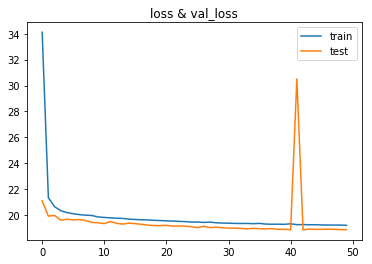

In [33]:
if 1:
    ### Save history
    History1_loss = History1.history['loss']
    History1_acc = History1.history['acc']
    History1_val_loss = History1.history['val_loss']
    History1_val_acc = History1.history['val_acc']

    thefile1 = open(outPath + 'History1_loss.txt', 'w')
    for item in History1_loss:
        thefile1.write("%s\n" % item)
    thefile1.close()

    thefile2 = open(outPath + 'History1_acc.txt', 'w')
    for item in History1_acc:
        thefile2.write("%s\n" % item)
    thefile2.close()

    thefile3 = open(outPath + 'History1_val_loss.txt', 'w')
    for item in History1_val_loss:
        thefile3.write("%s\n" % item)
    thefile3.close()

    thefile4 = open(outPath + 'History1_val_acc.txt', 'w')
    for item in History1_val_acc:
        thefile4.write("%s\n" % item)
    thefile4.close()

    ### Save model
    model_json1 = model_ex1.to_json()
    with open(outPath + "model_ex1.json", "w") as json_file:
        json_file.write(model_json1)
    model_ex1.save_weights(outPath + "weights_model_ex1.h5")
    print("Saved model to disk")
    
    ### Plot history of average covariance - accuracy and loss of the models
    plt.figure()
    plt.plot(History1.history['loss'])
    plt.plot(History1.history['val_loss'])
    plt.title('loss & val_loss')
    plt.legend(['train', 'test'], loc='upper right')
    plt.savefig(outPath + "loss", dpi=1000)
    
    plt.figure()
    plt.plot(History1.history['acc'])
    plt.plot(History1.history['val_acc'])
    plt.title('acc & val_acc')
    plt.legend(['train', 'test'], loc='upper right')
    plt.savefig(outPath + "acc", dpi=1000)
    plt.close()
    
    
#else:
#    print("already trained -- use saved model ")
#    model_ex1 = LoadModel(tmpPath + "model_ex1.json")
#    model_ex1.load_weights(tmpPath + "weights_model_ex1.h5")
##    model_ex1 = LoadModel(r"Data/tmp_data/trainGeb25/model_ex1.json")
##    model_ex1.load_weights(r"Data/tmp_data/trainGeb25/weights_model_ex1.h5")
#    #small
#    #model_ex1 = LoadModel(r"Data/tmp_data/model_ex1.json")
#    #model_ex1.load_weights(r"Data/tmp_data/weights_model_ex1.h5")
# 
    
print("read saved model for prediction ")
model_ex1 = LoadModel(outPath + "model_ex1.json")
model_ex1.load_weights(outPath + "weights_model_ex1.h5")
    
#print("after training or reading model ")
#model_ex1.summary()

In [31]:
from sklearn.metrics import accuracy_score
def testIndependet(fn, inpath, outpath):
    print("testIndependet: testing on image ",fn)
    image_arr = readImg(inpath + fn)
    print(image_arr.shape)
    
    if image_arr.shape[0] % 4 != 0:
        n = image_arr.shape[0] % 4
        new_x = image_arr.shape[0] - n
    else:
        new_x = image_arr.shape[0]


    if image_arr.shape[1] % 4 != 0:
        n = image_arr.shape[1] % 4
        new_y = image_arr.shape[1] - n
    else:
        new_y = image_arr.shape[1]

    image_arr = image_arr[:new_x, :new_y]
    print("image arr", image_arr.shape)
    
#    conc2 = np.reshape(model_ex1.predict(
#            np.reshape(image_arr, (1, image_arr.shape[0], image_arr.shape[1], 1))), 
#                       (image_arr.shape[0], image_arr.shape[1]))
    reshaped_image_arr = np.reshape(
            image_arr, (1, image_arr.shape[0], image_arr.shape[1], 1))
    print("resh : ",reshaped_image_arr.shape)
    #pred = model_ex1.predict(
    #        np.reshape(image_arr, (1, image_arr.shape[0], image_arr.shape[1], 1)))
    pred = model_ex1.predict(x=[reshaped_image_arr])
    print("resh : ",reshaped_image_arr.shape)
    print("pred : ",pred.shape)
    
    conc2 = np.reshape(pred,(image_arr.shape[0], image_arr.shape[1]))
    
    print("accuracy score: ")
    print(accuracy_score(image_arr.flatten().astype(bool), (conc2 > 0.5).flatten()))
    
    #fig = plt.figure(figsize=(image_arr.shape[1] / 1000, image_arr.shape[0] / 1000), dpi=100, frameon=False)
    #ax = plt.Axes(fig, [0., 0., 1., 1.])
    #ax.set_axis_off()
    #fig.add_axes(ax)
    
    #plt.imshow(conc2)
    #fig.savefig(outpath + fn[:-4] + '_out.png', dpi=1000)
    
    
    ## print image in bw (threshold 0.5)
    #fig = plt.figure(figsize=(image_arr.shape[1] / 1000, image_arr.shape[0] / 1000), dpi=100, frameon=False)
    #ax = plt.Axes(fig, [0., 0., 1., 1.])
    #ax.set_axis_off()
    #fig.add_axes(ax)
    #print("extremwerte : ",conc2.min)
    #print("extrem-grauwerte : ", conc2.max()," und ", conc2.min())

    concx = conc2 > 0.25
    #plt.imshow(concx, cmap=plt.cm.gray)
    #fig.savefig(outpath + fn[:-4] + '_out_bw.png', dpi=1000)
    #print("all images drawn and printed",outpath + fn[:-4] + '_out_bw.png')
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
    ax1.imshow(image_arr, cmap=plt.cm.gray)
    ax1.set_title('Input') 
    ax2.imshow(concx, cmap=plt.cm.gray)
    ax2.set_title('Prediction') 

testIndependet: testing on image  geb_9.png
(2500, 2500)
image arr (2500, 2500)
resh :  (1, 2500, 2500, 1)
resh :  (1, 2500, 2500, 1)
pred :  (1, 2500, 2500, 1)
accuracy score: 
0.99714016
testIndependet: testing on image  geb_10.png
(2295, 2460)
image arr (2292, 2460)
resh :  (1, 2292, 2460, 1)
resh :  (1, 2292, 2460, 1)
pred :  (1, 2292, 2460, 1)
accuracy score: 
0.984610664169


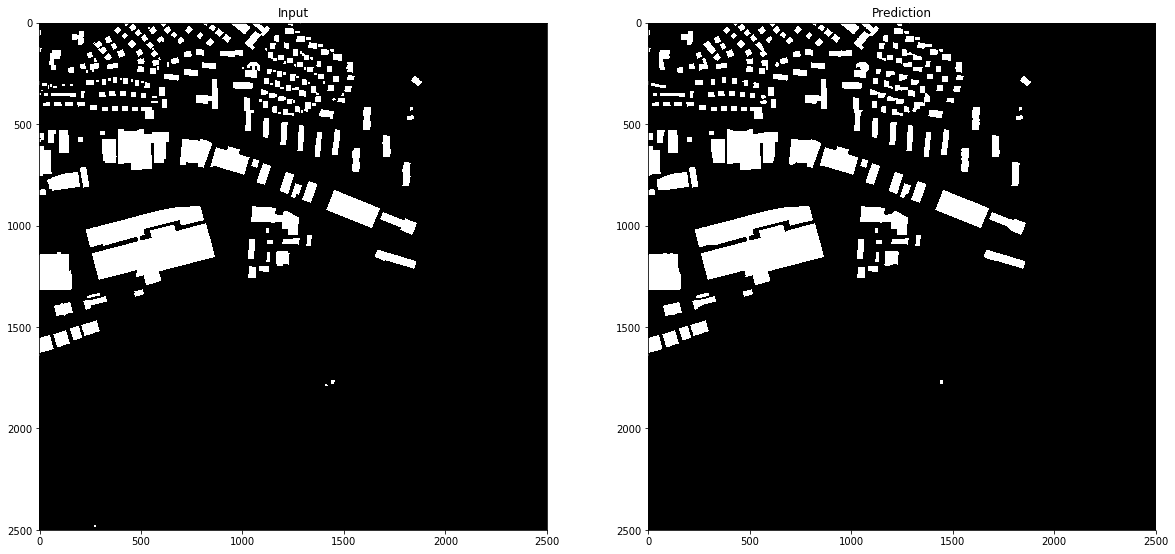

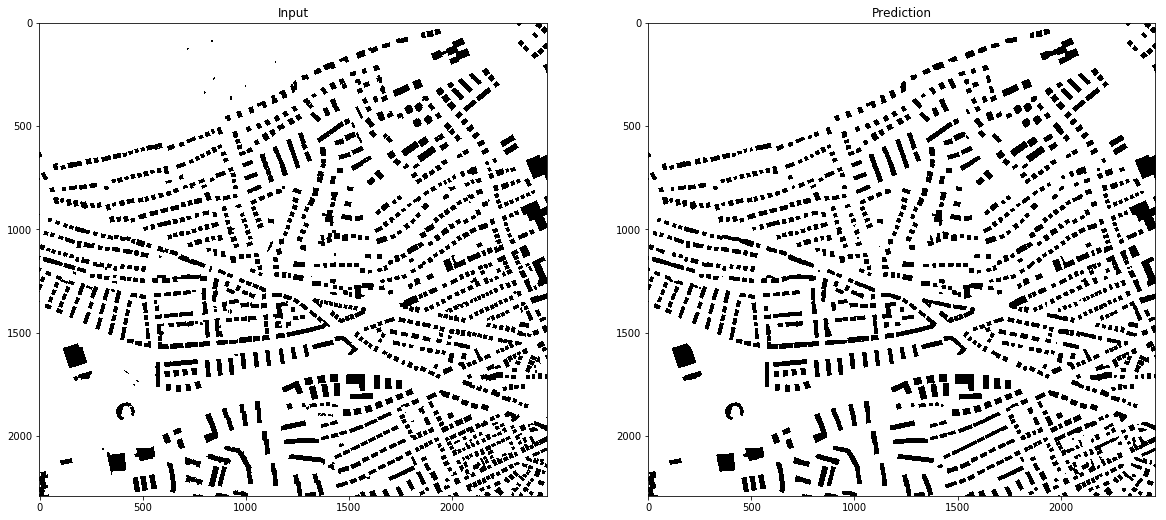

In [32]:
#testIndependet(r"geb_5.png", testPath, outPath)
#testIndependet(r"geb_5_small.png", testPath, outPath)
#testIndependet(r"geb_6.png", testPath, outPath)
#testIndependet(r"geb_7.png", testPath, outPath)
#testIndependet(r"geb_8_small.png", testPath, outPath)
#testIndependet(r"geb_8.png", testPath, outPath)
testIndependet(r"geb_9.png", testPath, outPath)
testIndependet(r"geb_10.png", testPath, outPath)